In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2023-12-05 11:18:22.231892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 載入資料
Data = pd.read_csv("0050 ETF Stock Price History.csv")

In [3]:
#這邊是先將資料載入後做統一格式的前處理
Data['Date'] = pd.to_datetime(Data['Date']) #將原始資料的時間轉為pandas的Time Series序列
Data.index=Data.Date
Data=Data.drop(['Date'],axis=1)
Data=Data.iloc[::-1] #因為原始資料的前後順序相反了 所以將資料倒過來
Data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-01-02,58.55,58.70,58.75,58.35,10.76M,-0.26%
2014-01-03,57.85,58.45,58.45,57.70,14.51M,-1.20%
2014-01-06,57.70,57.75,57.95,57.55,14.87M,-0.26%
2014-01-07,57.70,57.75,57.90,57.70,13.13M,0.00%
2014-01-08,57.80,57.70,57.95,57.70,7.61M,0.17%
...,...,...,...,...,...,...
2023-10-30,122.00,122.40,122.85,121.75,9.79M,-0.25%
2023-10-31,121.15,122.40,122.45,121.10,11.95M,-0.70%
2023-11-01,121.75,122.00,122.15,121.25,4.85M,0.50%


In [4]:
#vol. string改為float
def convert_vol_to_int(vol_str):
    multiplier = 1
    if 'K' in vol_str:
        multiplier = 10**3
    elif 'M' in vol_str:
        multiplier = 10**6
    elif 'B' in vol_str:
        multiplier = 10**9
    return int(float(vol_str.replace('K', '').replace('M', '').replace('B', '')) * multiplier)

Data['Vol.'] = Data['Vol.'].apply(convert_vol_to_int)

# change % 改為float
Data['Change %'] = Data['Change %'].str.rstrip('%').astype('float') / 100.0

Data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-01-02,58.55,58.70,58.75,58.35,10760000,-0.0026
2014-01-03,57.85,58.45,58.45,57.70,14510000,-0.0120
2014-01-06,57.70,57.75,57.95,57.55,14870000,-0.0026
2014-01-07,57.70,57.75,57.90,57.70,13130000,0.0000
2014-01-08,57.80,57.70,57.95,57.70,7610000,0.0017
...,...,...,...,...,...,...
2023-10-30,122.00,122.40,122.85,121.75,9790000,-0.0025
2023-10-31,121.15,122.40,122.45,121.10,11950000,-0.0070
2023-11-01,121.75,122.00,122.15,121.25,4850000,0.0050


In [5]:
# 選取要分析的特徵
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Data = Data[features]

In [6]:
Data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-01-02,58.55,58.70,58.75,58.35,10760000,-0.0026
2014-01-03,57.85,58.45,58.45,57.70,14510000,-0.0120
2014-01-06,57.70,57.75,57.95,57.55,14870000,-0.0026
2014-01-07,57.70,57.75,57.90,57.70,13130000,0.0000
2014-01-08,57.80,57.70,57.95,57.70,7610000,0.0017
...,...,...,...,...,...,...
2023-10-30,122.00,122.40,122.85,121.75,9790000,-0.0025
2023-10-31,121.15,122.40,122.45,121.10,11950000,-0.0070
2023-11-01,121.75,122.00,122.15,121.25,4850000,0.0050


In [7]:
from sklearn.preprocessing import MinMaxScaler

# 假設Data是包含六個特徵的資料框
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
X = Data[features]

# 初始化MinMaxScaler
scalers = {}

# 對每個特徵獨立進行縮放
for feature in features:
    scaler = MinMaxScaler(feature_range=(0, 1))
    X[feature] = scaler.fit_transform(X[[feature]])
    scalers[feature] = scaler

# X現在包含獨立縮放後的每個特徵的值


In [8]:
scaled_Data = X.values

In [9]:
# 創建時間窗口
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), :]    # 從資料集中提取一個時間窗口的資料，這個窗口的大小由 time_steps 決定。使用這個窗口的資料來預測下一個時間步的值
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])  # 預測的是股價，取第一列 (Price)
    return np.array(dataX), np.array(dataY)

# 設定時間窗口大小
time_steps = 10

# 創建時間窗口的訓練數據
X, y = create_dataset(scaled_Data, time_steps)

# 分割訓練集和測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = y[0:train_size], y[train_size:len(y)]

In [10]:
# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2]))) # X.shape[1] 是時間步數=10，X.shape[2] 是特徵數=6
model.add(LSTM(units=50)) # 這是再添加一層具有50個 LSTM 單元的 LSTM 層。
model.add(Dense(units=1)) # 添加一個具有一個神經元的全連接（Dense）層
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=1)

# 預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/10
60/60 [==============================] - 6s 11ms/step - loss: 0.0075
Epoch 2/10
60/60 [==============================] - 1s 9ms/step - loss: 3.6353e-04
Epoch 3/10
60/60 [==============================] - 1s 10ms/step - loss: 3.3995e-04
Epoch 4/10
60/60 [==============================] - 1s 9ms/step - loss: 3.3357e-04
Epoch 5/10
60/60 [==============================] - 1s 11ms/step - loss: 3.1085e-04
Epoch 6/10
60/60 [==============================] - 1s 11ms/step - loss: 3.2068e-04
Epoch 7/10
60/60 [==============================] - 1s 10ms/step - loss: 2.9535e-04
Epoch 8/10
60/60 [==============================] - 1s 11ms/step - loss: 2.9535e-04
Epoch 9/10
60/60 [==============================] - 1s 10ms/step - loss: 2.9516e-04
Epoch 10/10
15/15 [==============================] - 0s 4ms/step


In [11]:
# 反標準化預測結果
trainPredict = scalers['Price'].inverse_transform(trainPredict.reshape(-1, 1))
testPredict = scalers['Price'].inverse_transform(testPredict.reshape(-1, 1))

In [12]:
# 反標準化預測結果
trainY = scalers['Price'].inverse_transform(np.array([trainY]).T)
testY = scalers['Price'].inverse_transform(np.array([testY]).T)

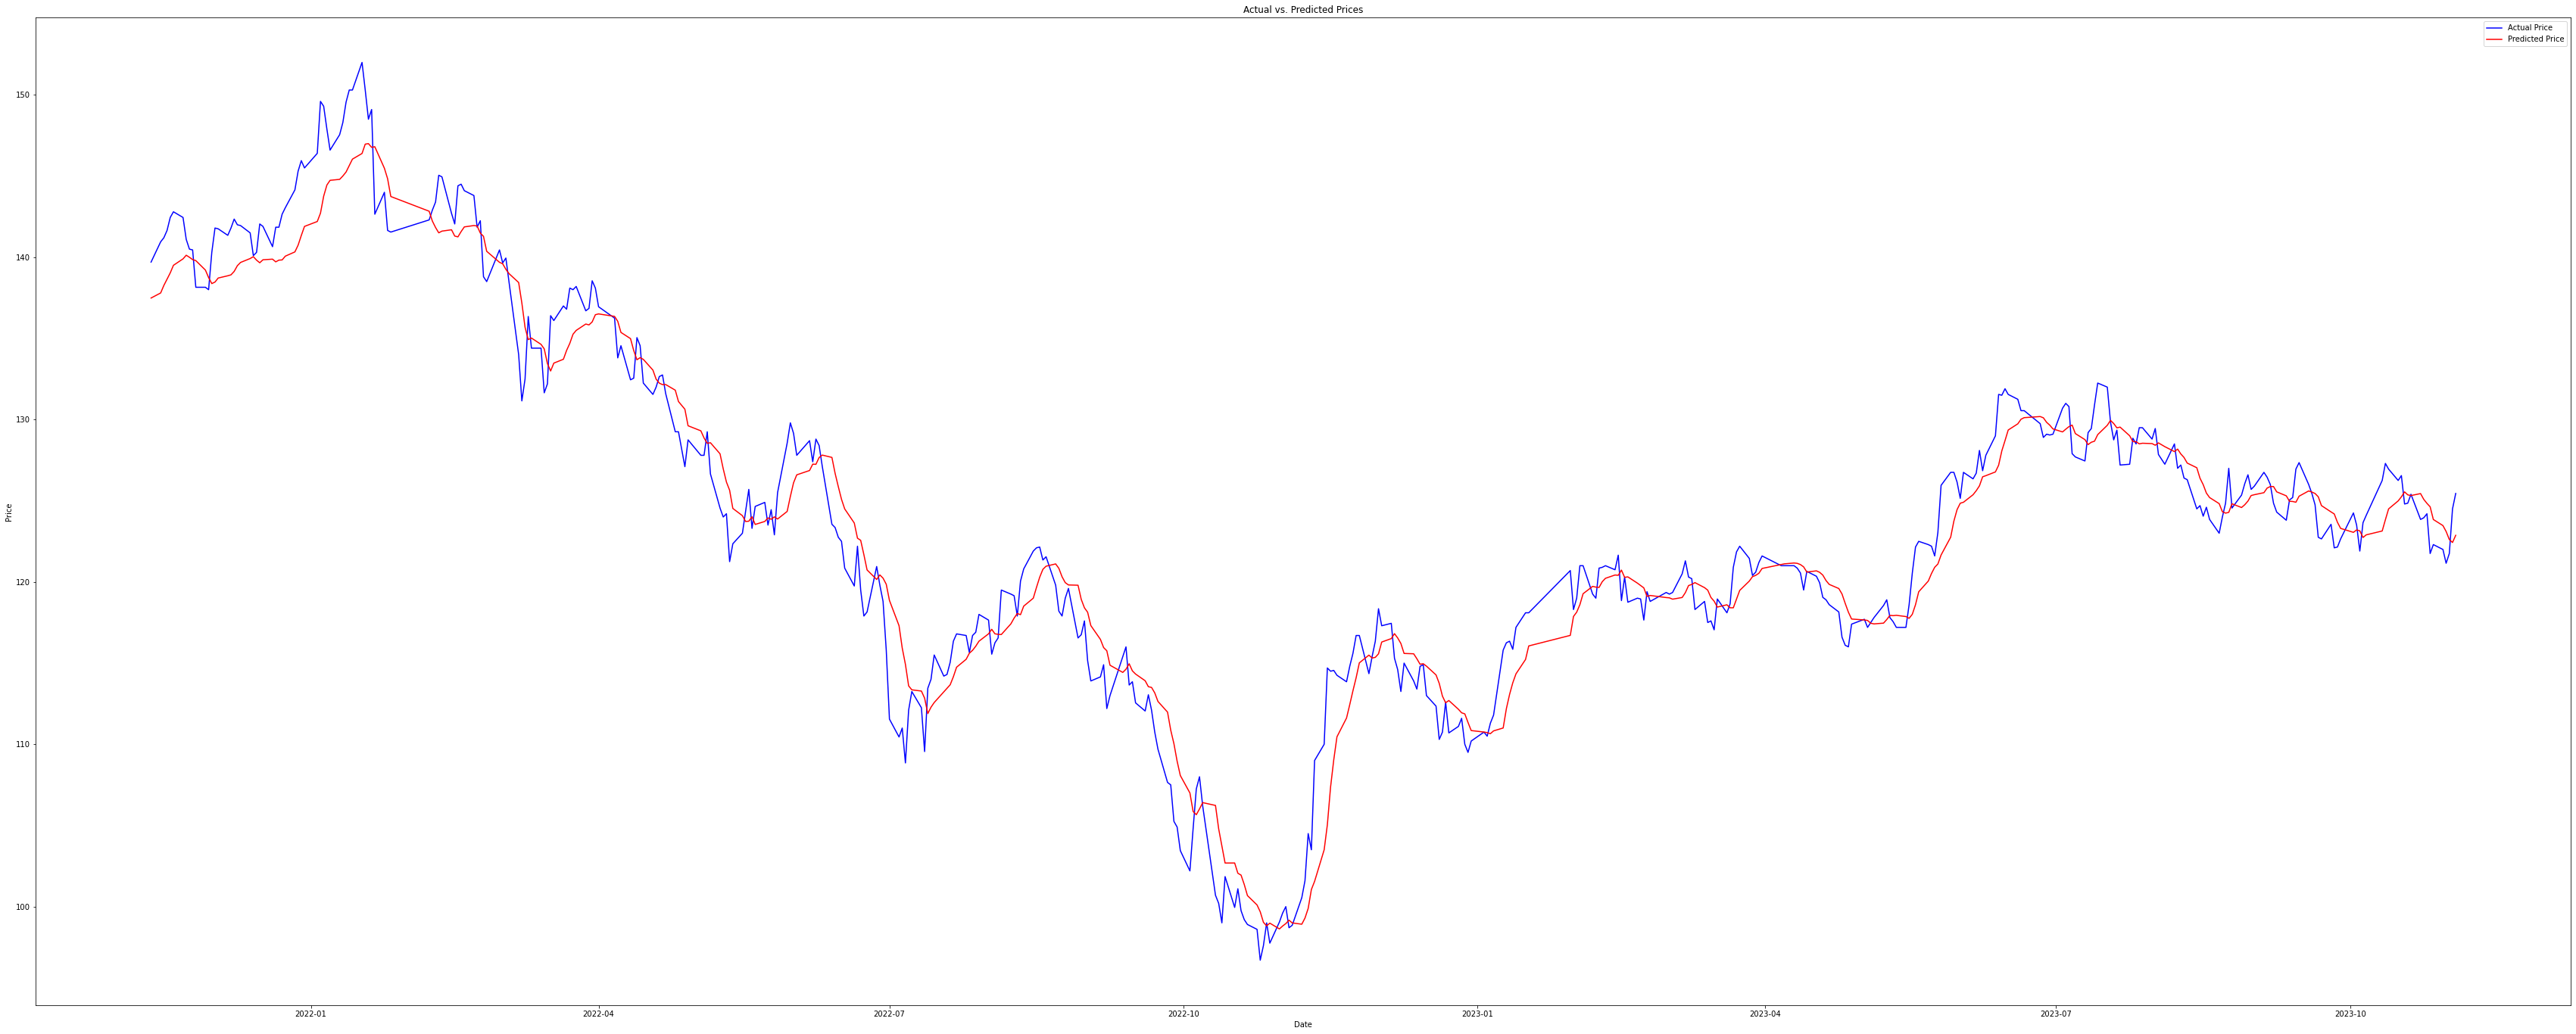

In [13]:
# 繪製實際價格和預測價格的對比圖
plt.figure(figsize=(60, 24))
plt.plot(Data.index[-len(testY):], testY, label='Actual Price', color='blue')
plt.plot(Data.index[-len(testY):], testPredict, label='Predicted Price', color='red')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import r2_score

# 計算R2分數
r2_score_value = r2_score(testY, testPredict)
print(f'R2 Score: {r2_score_value}')


R2 Score: 0.9586296562683633


In [15]:
from sklearn.metrics import mean_squared_error

# 計算RMSE
rmse = np.sqrt(mean_squared_error(testY, testPredict))
print(f'RMSE: {rmse}')


RMSE: 2.316187212546154
